# Introduction

Seeing that in Piazza, concerning the research question, you said: "If it's restaurant focused and using the data provided, I'll allow it."

I decided to ask the hypothesis question:
#### Are certain foods served more in certain neighborhoods?




*Before ultimately focusing on:*
#### Is the percetange of restaurants serving sushi correlated with the wealth of a neighborhood?

The yelp dataset and zipcodes dataset can aid me in this question.
The yelp dataset contained data (in True or False) about the types of food that is served there.
The zipcodes dataset contained information about a zipcodes's area wealth, including median family income, median household income, income per capita, etc.

These two datasets can be connect using zipcodes that they both provide in their datasets.

In [1]:
#Normal Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()
sns.set_context('talk')

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

In [2]:
#Filepaths
fp_ins = 'Data Finals/inspections.csv'
fp_res = 'Data Finals/restaurants.csv'
fp_vio = 'Data Finals/violations.csv'
fp_yel = 'Data Finals/yelp.csv'
fp_zip = 'Data Finals/zipcodes.csv'

#Reading the data
df_ins = pd.read_csv(fp_ins)
df_res = pd.read_csv(fp_res)
df_vio = pd.read_csv(fp_vio)
df_yel = pd.read_csv(fp_yel)
df_zip = pd.read_csv(fp_zip)

In [3]:
#Cleaning the data with Nan or Nulls
df_ins = df_ins.dropna(axis=1)
df_res = df_res.dropna(axis=1)
df_vio = df_vio.dropna(axis=1)
df_yel = df_yel.dropna(axis=1)
df_zip = df_zip.dropna(axis=1)

In [4]:
df_zip
df_zip.columns = ['zip','median_family_income','median_household_income','per_capita_income','percent_families_below_poverty_line','percent_snap_benefits','percent_supplemental_security_income','percent_nonwhite']

In [5]:
df_yel

,id,name,is_closed,rating,review_count,zip_code,latitude,longitude,hotdogs,sandwiches,...,italian,newamerican,chicken_wings,delis,bars,salad,seafood,bbq,bakeries,sushi
0,42nd-street-oyster-bar-rdu-airport-morrisville,42nd street oyster bar - rdu airport,False,2.5,23,27560,35.873808,-78.790896,False,False,...,False,True,False,False,False,False,True,False,False,False
1,aldi-foods-cary,aldi foods,False,4.0,17,27519,35.802840,-78.785930,False,False,...,False,False,False,False,False,False,False,False,False,False
2,luciano-pizzeria-ristorante-northwest-raleigh,luciano pizzeria ristorante,False,5.0,2,27612,35.839681,-78.678791,False,False,...,True,False,False,False,False,False,False,False,False,False
3,olive-garden-italian-restaurant-wilson,olive garden italian restaurant,False,3.0,16,27893,35.743170,-77.964160,False,False,...,True,False,False,False,False,True,False,False,False,False
4,subway-wilson-4,subway,False,3.5,3,27896,35.762936,-77.999428,True,True,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3683,carter-finley-stadium-raleigh,carter-finley stadium,False,3.5,23,27607,35.801217,-78.719568,False,False,...,False,False,False,False,False,False,False,False,False,False
3684,raleigh-little-theatre-raleigh,raleigh little theatre,False,3.5,24,27607,35.791430,-78.668820,False,False,...,False,False,False,False,False,False,False,False,False,False
3685,sky-zone-trampoline-park-durham-durham,"sky zone trampoline park, durham",False,4.0,12,27701,36.020901,-78.914003,False,False,...,False,False,False,False,False,False,False,False,False,False
3686,highgrove-estate-fuquay-varina,highgrove estate,False,3.5,4,27526,35.557201,-78.807747,False,False,...,False,False,False,False,False,False,False,False,False,False


# Cleaning up the Data

First, I clean-up the data for zipcodes.csv.

Whilst creating an array for clean_df_yel method.

In [6]:
df_yel = df_yel.rename(columns={'zip_code':'zip'})
zip_ar = df_zip['zip'].values

This clean_df_yel method allows me to check and then tag all yelp restaurants outside the range of zipcodes.csv using the apply method from Pandas.

After tagging all zipcodes outside the range of zipcodes.csv, I simply use the dropna method from Pandas to remove them. Leaving me with only zipcodes inside the range of zipcodes.csv

In [7]:
def clean_df_yel(int):
    if int in zip_ar:
        return int
    else:
        return np.nan

In [8]:
df_yel['zip'] = df_yel['zip'].apply(clean_df_yel)

#Checking and dropping any closed stores.
df_yel.drop(df_yel[df_yel.is_closed == True].index, inplace=True)
#Dropping the columns that serve no purpose in the context of my question
df_yel = df_yel.drop(columns=['is_closed','latitude','longitude'])

In [9]:
#Removes all the rows I tagged
df_yel = df_yel.dropna()

In [10]:
#As there are 38 different zipcodes in df_zip, I wanted to confirm that the same for our df_yel after cleaning up.
df_yel['zip'].unique().size

38

# Data Visualization

Below this is the averages of all columns based on zip. Which we will use later to merge with zipcodes to see wealth vs. types of food.

In [11]:
yel_avg_rating = df_yel.groupby(['zip']).mean()
df_yel['zip'] = df_yel['zip'].astype(int)

yel_avg_rating

,rating,review_count,hotdogs,sandwiches,pizza,tradamerican,burgers,mexican,grocery,breakfast_brunch,...,italian,newamerican,chicken_wings,delis,bars,salad,seafood,bbq,bakeries,sushi
zip,,,,,,,,,,,,,,,,,,,,,
27501.0,4.055556,25.888889,0.111111,0.222222,0.222222,0.111111,0.111111,0.000000,0.222222,0.000000,...,0.222222,0.111111,0.111111,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000
27502.0,3.610526,32.726316,0.126316,0.084211,0.094737,0.094737,0.063158,0.084211,0.031579,0.031579,...,0.031579,0.031579,0.042105,0.042105,0.021053,0.010526,0.052632,0.031579,0.010526,0.010526
27511.0,3.631841,42.179104,0.079602,0.079602,0.044776,0.064677,0.059701,0.059701,0.049751,0.029851,...,0.024876,0.024876,0.009950,0.029851,0.009950,0.014925,0.014925,0.004975,0.029851,0.034826
27513.0,3.707006,44.159236,0.114650,0.114650,0.101911,0.050955,0.063694,0.025478,0.050955,0.031847,...,0.031847,0.019108,0.038217,0.031847,0.025478,0.031847,0.031847,0.012739,0.025478,0.019108
27518.0,3.561856,39.969072,0.092784,0.123711,0.082474,0.061856,0.051546,0.030928,0.030928,0.020619,...,0.041237,0.030928,0.010309,0.030928,0.020619,0.030928,0.000000,0.030928,0.020619,0.041237
27519.0,3.610294,33.808824,0.117647,0.117647,0.044118,0.058824,0.073529,0.044118,0.102941,0.044118,...,0.000000,0.000000,0.000000,0.014706,0.000000,0.058824,0.000000,0.000000,0.044118,0.014706
27520.0,3.346154,17.128205,0.153846,0.128205,0.102564,0.102564,0.076923,0.076923,0.102564,0.051282,...,0.025641,0.051282,0.102564,0.076923,0.051282,0.025641,0.076923,0.051282,0.025641,0.025641
27522.0,3.000000,9.000000,0.500000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.250000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
27523.0,3.547619,26.952381,0.190476,0.095238,0.142857,0.047619,0.047619,0.095238,0.047619,0.047619,...,0.047619,0.000000,0.000000,0.095238,0.000000,0.047619,0.000000,0.000000,0.095238,0.000000


We can see from the graph below that the average median family income seems to be around the $70,000. 

Considering the median family income in the US is about $59,000 this group of neighborhood, on average, is pretty wealthy.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


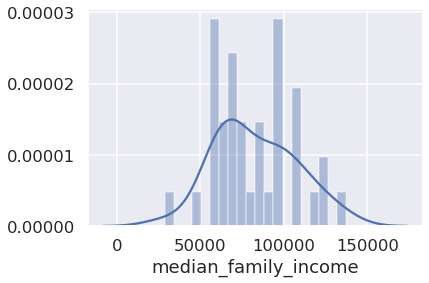

In [12]:
sns.distplot(df_zip['median_family_income'], bins= 20)

In [13]:
df_zip

,zip,median_family_income,median_household_income,per_capita_income,percent_families_below_poverty_line,percent_snap_benefits,percent_supplemental_security_income,percent_nonwhite
0,27501,59408,51121,21631,10.5,15.5,5.2,17.9
1,27502,109891,95857,36763,3.4,2.4,0.8,18.9
2,27511,82292,67392,33139,9.6,4.5,2.2,24.8
3,27513,109736,87262,41232,3.8,2.4,1.5,27.8
4,27518,125432,98247,49865,5.5,1.0,1.7,19.9
5,27519,137193,121815,45778,3.2,2.3,2.3,35.2
6,27520,67939,58455,25628,5.0,7.8,2.4,23.5
7,27522,66250,59221,25513,6.0,7.0,4.2,31.4
8,27523,89184,68342,36976,3.1,3.1,1.8,22.4
9,27526,74666,66025,28074,8.4,8.3,3.9,22.5


#### Merging the Data

In [14]:
df_yel_zip = pd.merge(df_zip,yel_avg_rating,on='zip')
df_yel_zip

,zip,median_family_income,median_household_income,per_capita_income,percent_families_below_poverty_line,percent_snap_benefits,percent_supplemental_security_income,percent_nonwhite,rating,review_count,...,italian,newamerican,chicken_wings,delis,bars,salad,seafood,bbq,bakeries,sushi
0,27501,59408,51121,21631,10.5,15.5,5.2,17.9,4.055556,25.888889,...,0.222222,0.111111,0.111111,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000
1,27502,109891,95857,36763,3.4,2.4,0.8,18.9,3.610526,32.726316,...,0.031579,0.031579,0.042105,0.042105,0.021053,0.010526,0.052632,0.031579,0.010526,0.010526
2,27511,82292,67392,33139,9.6,4.5,2.2,24.8,3.631841,42.179104,...,0.024876,0.024876,0.009950,0.029851,0.009950,0.014925,0.014925,0.004975,0.029851,0.034826
3,27513,109736,87262,41232,3.8,2.4,1.5,27.8,3.707006,44.159236,...,0.031847,0.019108,0.038217,0.031847,0.025478,0.031847,0.031847,0.012739,0.025478,0.019108
4,27518,125432,98247,49865,5.5,1.0,1.7,19.9,3.561856,39.969072,...,0.041237,0.030928,0.010309,0.030928,0.020619,0.030928,0.000000,0.030928,0.020619,0.041237
5,27519,137193,121815,45778,3.2,2.3,2.3,35.2,3.610294,33.808824,...,0.000000,0.000000,0.000000,0.014706,0.000000,0.058824,0.000000,0.000000,0.044118,0.014706
6,27520,67939,58455,25628,5.0,7.8,2.4,23.5,3.346154,17.128205,...,0.025641,0.051282,0.102564,0.076923,0.051282,0.025641,0.076923,0.051282,0.025641,0.025641
7,27522,66250,59221,25513,6.0,7.0,4.2,31.4,3.000000,9.000000,...,0.250000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,27523,89184,68342,36976,3.1,3.1,1.8,22.4,3.547619,26.952381,...,0.047619,0.000000,0.000000,0.095238,0.000000,0.047619,0.000000,0.000000,0.095238,0.000000
9,27526,74666,66025,28074,8.4,8.3,3.9,22.5,3.596154,18.846154,...,0.038462,0.009615,0.038462,0.028846,0.019231,0.019231,0.009615,0.028846,0.028846,0.009615


#### Where I'd get my question from?

At first, I started with is there any correlation between food and the wealth of the neighborhood.

Looking at this graph, I saw a decent spurious correlation between sushi and the median family income, so I focused my question deeply on one specfic item and investigated further to confirm whether it's coincidence or correlated.
Logically speaking, it shouldn't be autocorrelated as well.

## Approaching the data

I figured to use Inferential Analysis because I felt like there was a trend between the two variables and then using linear regression to see if there really was a relationship and the magnitude of said relationship.

The percentage of restaurants serving sushi and median family income also wasn't too correlated which avoided multicollinearity.

In [15]:
df_yel_zip.corr()

,zip,median_family_income,median_household_income,per_capita_income,percent_families_below_poverty_line,percent_snap_benefits,percent_supplemental_security_income,percent_nonwhite,rating,review_count,...,italian,newamerican,chicken_wings,delis,bars,salad,seafood,bbq,bakeries,sushi
zip,1.000000,-0.209730,-0.361328,-0.027070,0.306144,0.314024,0.078607,0.297128,0.054443,0.238587,...,-0.226750,-0.015034,-0.252479,0.062245,0.149235,-0.193541,-0.040978,0.034330,-0.078082,0.039407
median_family_income,-0.209730,1.000000,0.881468,0.903884,-0.723360,-0.763552,-0.518530,-0.515274,0.063763,0.047190,...,-0.223139,-0.137686,-0.279719,-0.020462,-0.059411,0.075115,-0.026561,-0.153126,0.243230,0.544693
median_household_income,-0.361328,0.881468,1.000000,0.724968,-0.695488,-0.700279,-0.477990,-0.400670,0.055314,-0.128220,...,-0.135859,-0.230575,-0.156840,-0.020126,-0.204214,0.088028,-0.067250,-0.112663,0.098083,0.433652
per_capita_income,-0.027070,0.903884,0.724968,1.000000,-0.619224,-0.703885,-0.471805,-0.457737,0.142334,0.207210,...,-0.257474,-0.057135,-0.337431,-0.041289,0.048815,0.037221,-0.040730,-0.207494,0.204590,0.592079
percent_families_below_poverty_line,0.306144,-0.723360,-0.695488,-0.619224,1.000000,0.876882,0.618236,0.636133,0.120144,0.428886,...,0.042342,0.309024,0.035861,-0.038559,0.337454,-0.055070,-0.000131,-0.020172,-0.075597,-0.242945
percent_snap_benefits,0.314024,-0.763552,-0.700279,-0.703885,0.876882,1.000000,0.493867,0.595707,0.005017,0.295384,...,0.227838,0.383641,0.191107,0.023802,0.316900,0.047265,-0.019888,0.015259,-0.019853,-0.365445
percent_supplemental_security_income,0.078607,-0.518530,-0.477990,-0.471805,0.618236,0.493867,1.000000,0.203640,0.438762,0.004610,...,0.045293,0.152785,0.049327,-0.181765,0.119398,-0.160368,-0.203176,-0.084870,-0.137060,-0.364715
percent_nonwhite,0.297128,-0.515274,-0.400670,-0.457737,0.636133,0.595707,0.203640,1.000000,-0.308664,0.274138,...,0.075728,-0.019804,0.142168,0.252871,0.118737,0.002414,0.185310,-0.077640,-0.135078,-0.147006
rating,0.054443,0.063763,0.055314,0.142334,0.120144,0.005017,0.438762,-0.308664,1.000000,0.163282,...,-0.166083,0.273481,-0.403782,-0.399224,0.014903,0.251908,-0.311132,0.016066,0.087839,-0.090593
review_count,0.238587,0.047190,-0.128220,0.207210,0.428886,0.295384,0.004610,0.274138,0.163282,1.000000,...,-0.282362,0.411062,-0.385352,-0.017834,0.647322,-0.062694,0.022137,0.072462,0.071560,0.246199


#### Graphing the relationship

In [16]:
med_fam_income_v = df_yel_zip['median_family_income'].values.tolist()
sushi_v = df_yel_zip['sushi'].values.tolist()

a1, b1 = np.polyfit(med_fam_income_v,sushi_v,1)

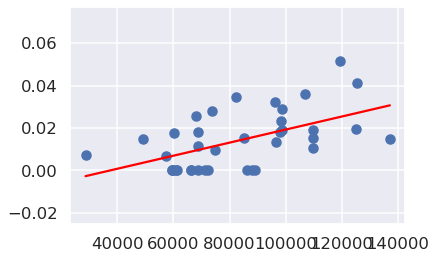

In [17]:
x1 = np.arange(min(df_yel_zip['median_family_income']),max(df_yel_zip['median_family_income']))

plt.scatter(med_fam_income_v, sushi_v)
plt.plot(x1, a1 * x1 + b1, color = "red")

Looking at this graph, confirmed that Inferential Analysis was the right approach, the graph showed a straight line showing a linear relationship.
Similarly, there doesn't seem to be any sign of multivariate normality, where the data points are spread out between the typical range of a median family income.
Not homoscedastic as well. 
Which ticks all the assumptions for Inferential Analysis: Regression.

Looking below, I tried using the pivot table to see how an ordered list would look like. Similar to the graph, the percentage of restaurants serving sushi rose from 0 starting from around the lower half of the list.

In [18]:
sushi_pv = pd.pivot_table(df_yel_zip,values = 'sushi',index='median_family_income')
sushi_pv

,sushi
median_family_income,
28641,0.007194
49213,0.014925
57419,0.007042
59395,0.000000
59408,0.000000
59892,0.000000
60033,0.017857
60783,0.000000
61324,0.000000


#### Using OLS (Ordinary Least Squares) 

In [19]:
outcome_1,predictors_1 = patsy.dmatrices('median_family_income~sushi',df_yel_zip)
mod_1 = sm.OLS(outcome_1,predictors_1)
res_1 = mod_1.fit()

In [20]:
print(res_1.summary())

                             OLS Regression Results                             
Dep. Variable:     median_family_income   R-squared:                       0.297
Model:                              OLS   Adj. R-squared:                  0.277
Method:                   Least Squares   F-statistic:                     15.19
Date:                  Wed, 10 Jun 2020   Prob (F-statistic):           0.000407
Time:                          14:01:02   Log-Likelihood:                -430.29
No. Observations:                    38   AIC:                             864.6
Df Residuals:                        36   BIC:                             867.9
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6.948e+04   4821.461

The OLS Regression shows that there is an upwards trend for the Median Family Income as the percentage of restaurants serving sushi increases as well. To translate the sushi coefficient, the median household income increases by 966.10 dollars for each 1 percent increase in restaurants serving sushi.

The OLS also shows that the P-value is smaller than 0.000, meaning that we can reject the Null Hypothesis or that there is indeed a pattern betweeen percentage of restaurants serving sushi versus the median family income.

Even with P-value support this, to confirm that this isn't just a coincidence,  I propose that we try the same thing with median household income instead. If median household income gets similar results, it confirms that this pattern relates to the wealth of the neighboorhood.

In [21]:
med_hh_income_v = df_yel_zip['median_household_income'].values.tolist()
a2, b2 = np.polyfit(med_hh_income_v,sushi_v,1)

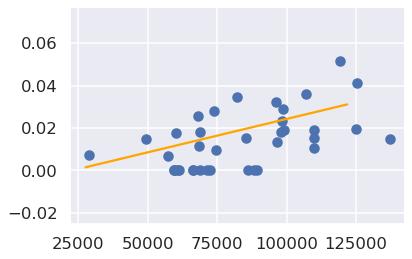

In [22]:
x2 = np.arange(min(df_yel_zip['median_household_income']),max(df_yel_zip['median_household_income']))
plt.scatter(med_fam_income_v, sushi_v)
plt.plot(x2, a2 * x2 + b2, color = "orange")

In [23]:
outcome_2,predictors_2 = patsy.dmatrices('median_household_income~sushi',df_yel_zip)
mod_2 = sm.OLS(outcome_2,predictors_2)
res_2 = mod_2.fit()

In [24]:
print(res_2.summary())

                               OLS Regression Results                              
Dep. Variable:     median_household_income   R-squared:                       0.188
Model:                                 OLS   Adj. R-squared:                  0.165
Method:                      Least Squares   F-statistic:                     8.338
Date:                     Wed, 10 Jun 2020   Prob (F-statistic):            0.00653
Time:                             14:01:03   Log-Likelihood:                -423.50
No. Observations:                       38   AIC:                             851.0
Df Residuals:                           36   BIC:                             854.3
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
In

In [25]:
per_cap_income_v = df_yel_zip['per_capita_income'].values.tolist()
a3, b3 = np.polyfit(per_cap_income_v,sushi_v,1)

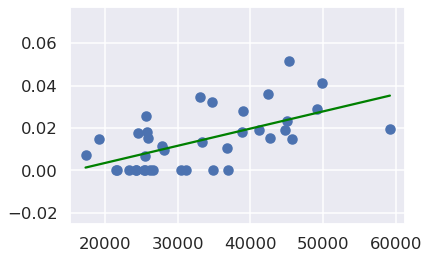

In [26]:
x3 = np.arange(min(df_yel_zip['per_capita_income']),max(df_yel_zip['per_capita_income']))
plt.scatter(per_cap_income_v, sushi_v)
plt.plot(x3, a3 * x3 + b3, color = "green")

In [27]:
outcome_3,predictors_3 = patsy.dmatrices('per_capita_income~sushi',df_yel_zip)
mod_3 = sm.OLS(outcome_3,predictors_3)
res_3 = mod_3.fit()

In [28]:
print(res_3.summary())

                            OLS Regression Results                            
Dep. Variable:      per_capita_income   R-squared:                       0.351
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     19.43
Date:                Wed, 10 Jun 2020   Prob (F-statistic):           9.02e-05
Time:                        14:01:03   Log-Likelihood:                -395.05
No. Observations:                  38   AIC:                             794.1
Df Residuals:                      36   BIC:                             797.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.692e+04   1907.501     14.112      0.0

# Conclusion

Both Per Capita Income and Median Household Income showed the same patterns as Median Family Income, Per Capita also had a less than 0.000 p-value while Median Family Income had a 0.007, considering the typical P-value to reject the Null Hypotehsis is 0.05, all our OLS Regression results showed that we can accept the can reject the Null Hypothesis and confirm our Alternative Hypothesis that there is a correlation between percentage of restaurants serving sushi and the wealth of the neighborhoods.
Although, to know why is another problem. It could be that sushi restaurants whose owner lives nearby, on average, earn more thus improving the median income or wealth of the neighborhood. Or it could be that more wealthier neighborhoods have people that can afford or enjoy sushi more, thus more sushi is put in their menu.

Although, based on the limitations and small collection of data, I can only confirm this pattern for the small neighborhoods that the data "zip_code" had. 
Any reliable inference to a larger neighborhood needs to be supported with a larger quantity of data that spans states or countries.

Though this data isn't Earth-shattering, it believe it does have some uses. If this pattern can be supported with more data, it can be used to recommend areas that might have sushi. 
For example, let's say yelp doesn't have complete data in a new country it just tried to reach out to, the customer wants to eat sushi, maybe due to the limited data or lack of actually sushi restaurants, it can't find one inside the city. It can instead try to recommend going to certain areas of higher wealth that has a better chance of finding restaurants that has a sidemenu serving sushi.